In [9]:
import pysam
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

In [2]:
def get_coverage(bam_path):
    with pysam.AlignmentFile(bam_path, 'rb') as alignment:
        assert(alignment.check_index())
        n_ref = len(alignment.references)
        coverages = []
        ref_lens = []
        for ref in alignment.references:
            ref_len = alignment.get_reference_length(alignment.references[0])
            curr_coverage = np.zeros(ref_len)
            positions = []
            for read in tqdm_notebook(alignment.fetch(ref)):
                curr_coverage[read.reference_start:read.reference_end] +=1
            coverages.append(curr_coverage)
        return coverages[0] if n_ref == 1 else coverages
    
def coverage_plot(coverage, bin_width=200, lab_step=4, k=1000):
    from math import ceil
    ref_len = len(coverage)
    cov_percent = len(coverage == 0)/ref_len*100
    mean_cov = round(np.mean(coverage), 3)
    l = ceil(ref_len/bin_width)
    to_plot = np.zeros(shape = l)
    labels = np.chararray(l, itemsize=10)
    rng = range(0, ref_len, bin_width)
    for i, j in enumerate(rng):
        to_plot[i] = np.mean(coverage[j:j+bin_width])
        labels[i] = f'{j//k}k-{(j+bin_width-1)//k}k'
    fig, ax = plt.subplots(figsize = [16, 9])
    ax.plot(rng, to_plot, 
            label=f'Mean coverage = {mean_cov}\nCoverage % = {cov_percent}\nBinsize = {bin_width}')
    ax.grid()
    ax.set_xlabel('Reference bp')
    ax.set_ylabel('Coverage')
    ax.set_title('Coverage plot')
    
    def decoder(x):
        return map(lambda el: el.decode(), x)

    ax.set_xticks(rng[::lab_step])
    ax.set_xticklabels(decoder(labels[::lab_step]))
    ax.legend()
    
def get_tlen_dist(bam_path, outlier_cutoff=99.9):
    with pysam.AlignmentFile(bam_path, 'rb') as alignment:
        assert(alignment.check_index())
        tlens = []
        for read in alignment.fetch():
            if read.is_proper_pair:
                tlens.append(read.tlen)
        tlens = np.array(tlens)
        return tlens[np.logical_and(tlens<np.percentile(tlens, outlier_cutoff), tlens>=0)]
    
def min_width_interval(data, dens=95, disc_freq=50):
    min_width = np.Inf
    min_pair = None
    for sp, fp in zip(np.linspace(0, 100-dens, disc_freq), 
                      np.linspace(dens, 100, disc_freq)):
        start = np.percentile(data, sp)
        finish = np.percentile(data, fp)
        width = finish-start
        if width < min_width:
            min_width = width
            min_pair = (start, finish)
    return min_pair

def tlen_plot(tlens):
    std_tlen = round(tlens.std(), 3)
    mean_tlen = round(tlens.mean(), 3)
    interval = min_width_interval(tlens)
    fig, ax = plt.subplots(figsize=[16, 9])
    sns.distplot(tlens, kde=False, norm_hist=False, 
                 label = f'Mean insert size = {mean_tlen}\nSTD of insert size = {std_tlen}')
    ax.scatter(interval, [0, 0], marker='X', color='red', s=100, label='Minimum width 95% density interval')
    ax.plot(interval, [0, 0], linestyle='--')
    ax.legend()
    ax.set_xticks(np.linspace(np.min(tlens),
                             np.max(tlens), 10).round(-1))
    ax.grid()

def sub_mat(bam_path, ref_path, alphabet=['A', 'C', 'G', 'T']):
    sub_mat = pd.DataFrame(np.zeros((len(alphabet), len(alphabet))), index=alphabet, columns=alphabet)
    with pysam.AlignmentFile(bam_path, 'rb') as alignment, pysam.Fastafile(ref_path) as ref:
        for ref_contig in alignment.references:
            ref_str = ref.fetch(ref_contig)
            for read in tqdm_notebook(alignment.fetch(ref_contig)):
                for qi, ri in read.get_aligned_pairs():
                    if (qi != None) and (ri != None) and (read.seq[qi] != ref_str[ri])\
                    and (read.seq[qi] in alphabet):
                        sub_mat.loc[read.seq[qi], ref_str[ri]] +=1 
                    '''
                    if (ref_base!=None) and (ref_base != ref_base.upper()):
                        sub_mat.loc[read.seq[qi], ref_base.upper()] +=1 
                    '''
    return sub_mat

# Test data:

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

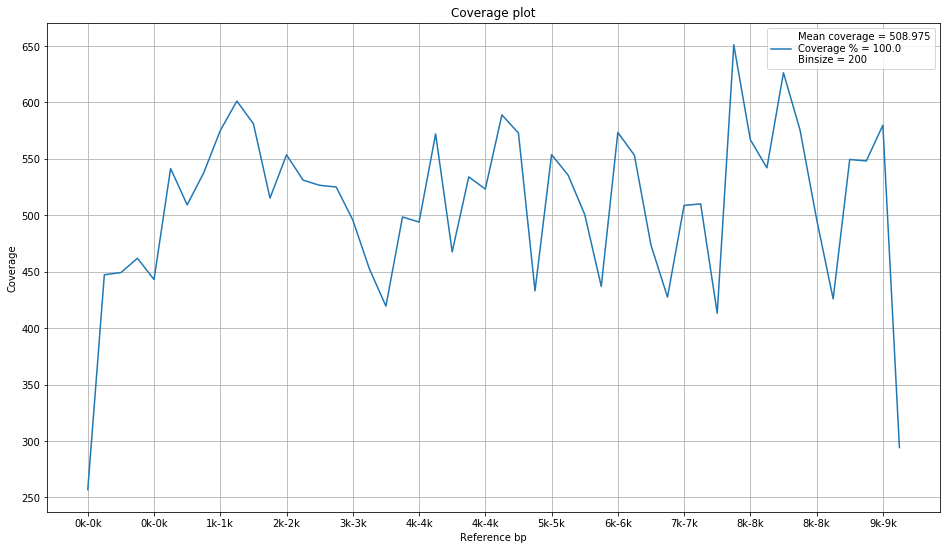

In [3]:
coverage_plot(get_coverage('test_sorted.bam'))

/home/dmitry/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


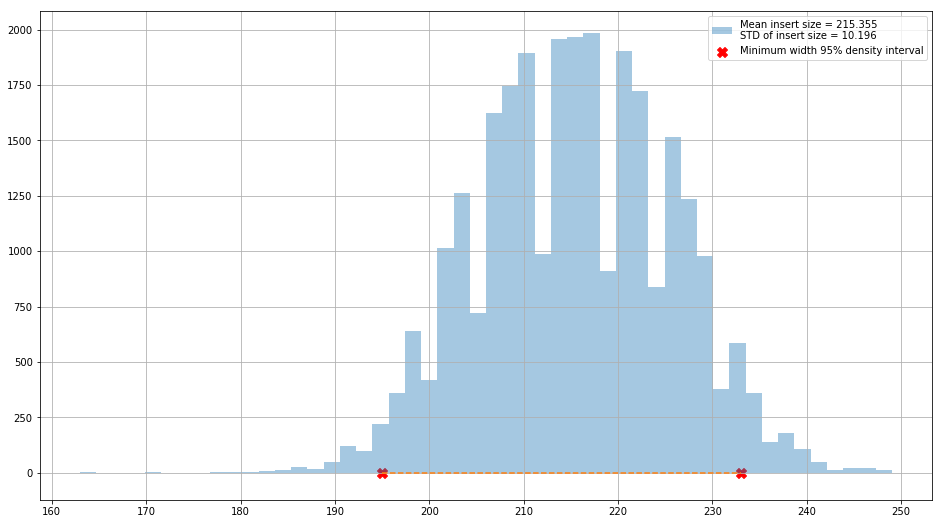

In [4]:
tlens = get_tlen_dist('test_sorted.bam', outlier_cutoff=100)
tlen_plot(tlens)

In [5]:
sm = sub_mat('test_sorted.bam','Data/Assignment_2/Test/MG1655-K12.first10K.fasta', ['A', 'C', 'G', 'T'])
sm

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

,A,C,G,T
A,0.0,0.0,0.0,0.0
C,15.0,0.0,21.0,0.0
G,19.0,2.0,0.0,16.0
T,1.0,1.0,34.0,0.0


Parallel implementation test:

In [11]:
!time mpirun -np 4 python sub_mat_parallel.py -b test_sorted.bam -ref Data/Assignment_2/Test/MG1655-K12.first10K.fasta -o tres.csv
print(pd.read_csv('tres.csv', index_col=0))
_ = gc.collect()

3.25user 0.25system 0:00.89elapsed 392%CPU (0avgtext+0avgdata 58900maxresident)k
0inputs+0outputs (0major+54346minor)pagefaults 0swaps
      A    C     G     T
A   0.0  0.0   0.0   0.0
C  15.0  0.0  21.0   0.0
G  19.0  2.0   0.0  16.0
T   1.0  1.0  34.0   0.0


# B.faecium data

All the shell commands I used to align reads are listed in the file Journal2a.txt.

### Dataset #1:

In [13]:
bam_path1 = 'Data/Assignment_2/bfaecium1_s.bam'
ref_path = 'Data/Assignment_2/B.faecium/ref.fasta'

99.7% of reads have aligned:

In [231]:
!samtools flagstat Data/Assignment_2/bfaecium1_s.bam

3432529 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
165 + 0 supplementary
0 + 0 duplicates
3424657 + 0 mapped (99.77% : N/A)
3432364 + 0 paired in sequencing
1716182 + 0 read1
1716182 + 0 read2
3407384 + 0 properly paired (99.27% : N/A)
3416620 + 0 with itself and mate mapped
7872 + 0 singletons (0.23% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [14]:
cov1 = get_coverage(bam_path1)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

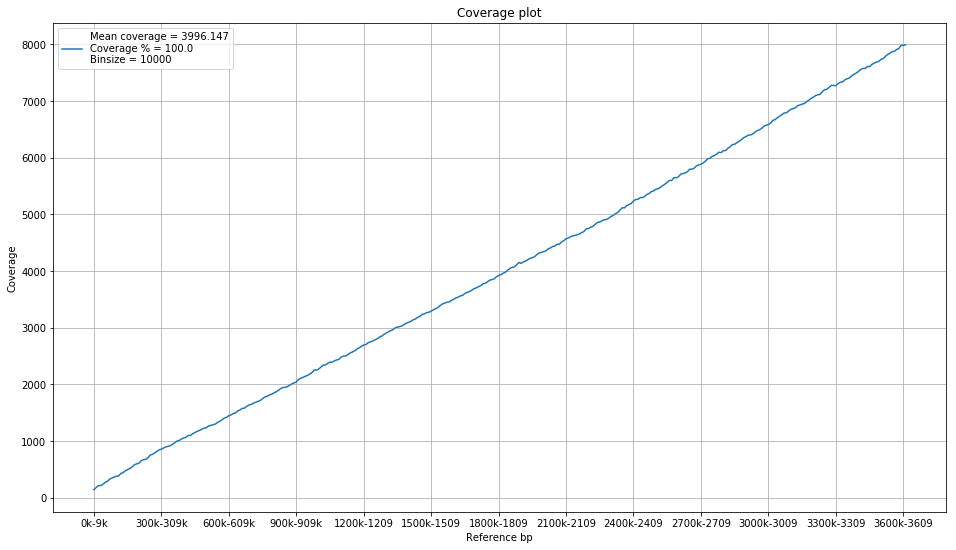

In [15]:
coverage_plot(cov1, bin_width=10000, lab_step=30)

In [16]:
tlens1 = get_tlen_dist(bam_path1, outlier_cutoff=99.9)

/home/dmitry/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


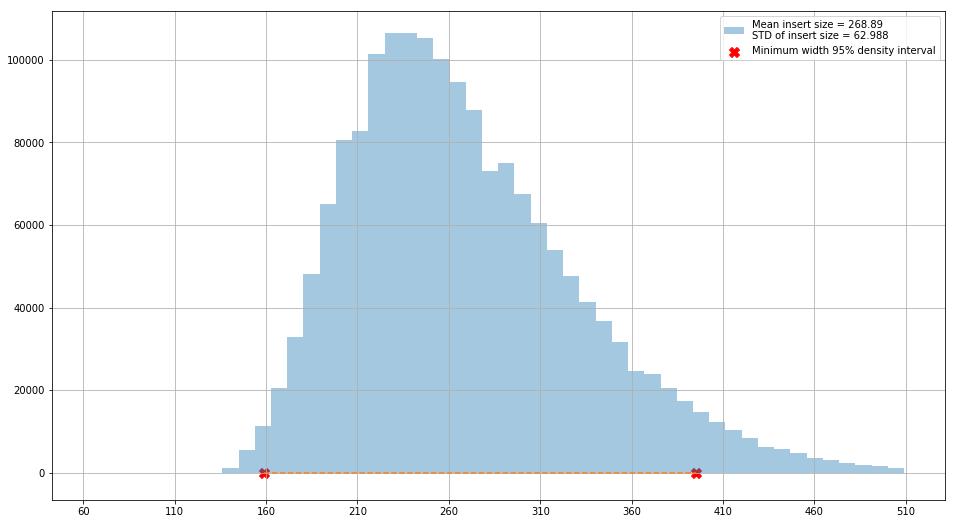

In [17]:
tlen_plot(tlens1)

In [28]:
!mpirun -np 4 python sub_mat_parallel.py -b Data/Assignment_2/bfaecium1_s.bam -ref Data/Assignment_2/B.faecium/ref.fasta -o bf1.csv

In [303]:
pd.read_csv('bf1.csv', index_col=0)

,A,C,G,T
A,0.0,573779.0,222038.0,105845.0
C,1464356.0,0.0,1112636.0,840420.0
G,846317.0,1113628.0,0.0,1477178.0
T,104972.0,220664.0,575060.0,0.0


### Dataset #2:

In [18]:
bam_path2 = 'Data/Assignment_2/bfaecium2_s.bam'

98.86% of reads have aligned:

In [29]:
!samtools flagstat Data/Assignment_2/bfaecium2_s.bam

4328969 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
13369 + 0 supplementary
0 + 0 duplicates
4279501 + 0 mapped (98.86% : N/A)
4315600 + 0 paired in sequencing
2157800 + 0 read1
2157800 + 0 read2
3764298 + 0 properly paired (87.23% : N/A)
4216854 + 0 with itself and mate mapped
49278 + 0 singletons (1.14% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [21]:
cov2 = get_coverage(bam_path2)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

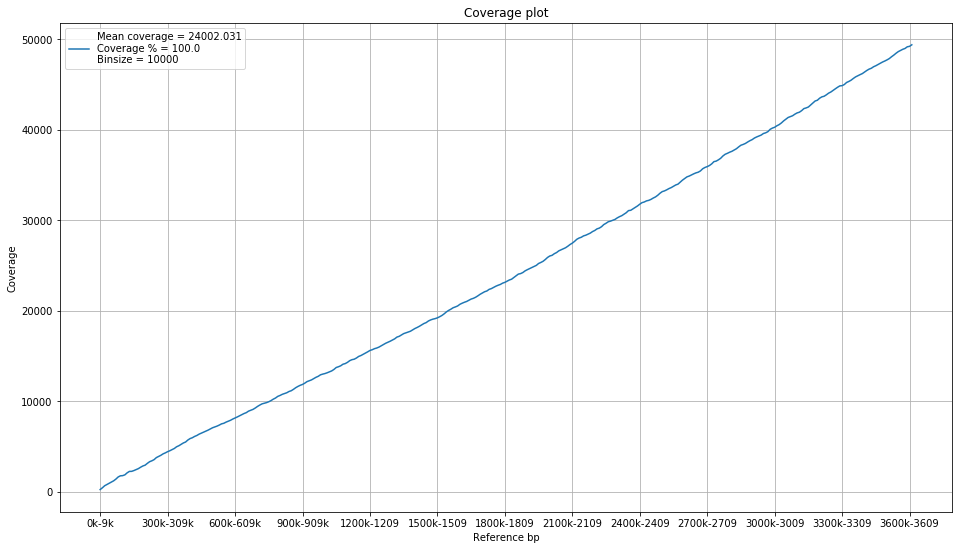

In [22]:
coverage_plot(cov2, bin_width=10000, lab_step=30)

In [23]:
tlens2 = get_tlen_dist(bam_path2, outlier_cutoff=99.9)

/home/dmitry/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


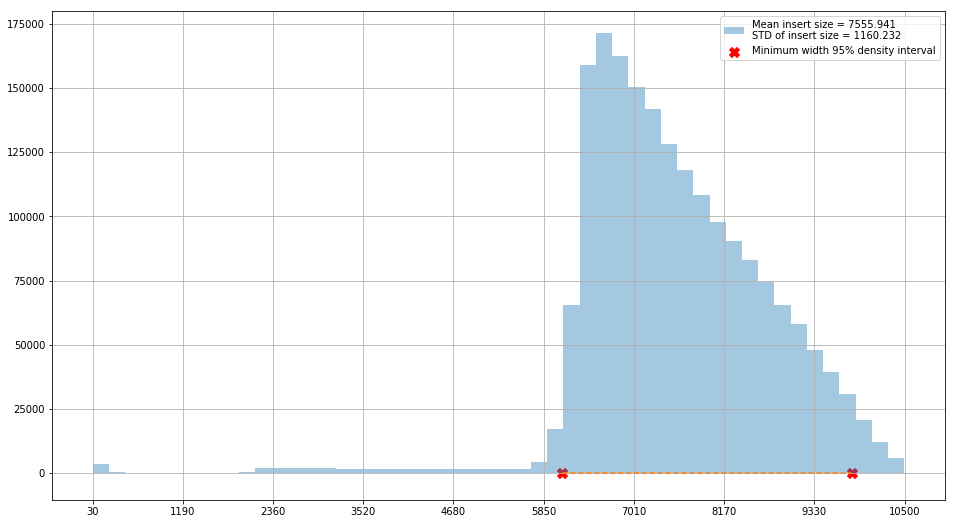

In [24]:
tlen_plot(tlens2)

In [26]:
!mpirun -np 4 python sub_mat_parallel.py -b Data/Assignment_2/bfaecium2_s.bam -ref Data/Assignment_2/B.faecium/ref.fasta -o bf2.csv

In [27]:
pd.read_csv('bf2.csv', index_col=0)

,A,C,G,T
A,0.0,144778.0,74508.0,44396.0
C,873929.0,0.0,480768.0,506815.0
G,515943.0,487220.0,0.0,887473.0
T,44330.0,75391.0,145191.0,0.0
